# Class 22: Confidence intervals

Plan for today:
- Hypothesis tests for comparing two means
- Confidence intervals


## Notes on the class Jupyter setup

If you have the *ydata123_2024a* environment set up correctly, you can get the class code using the code below (which presumably you've already done given that you are seeing this notebook).  

In [27]:
import YData

# YData.download.download_class_code(22)   # get class code    
# YData.download.download_class_code(22, TRUE) # get the code with the answers 

YData.download_data("babies.csv")

The file `babies.csv` already exists.
If you would like to download a new copy of the file, please rename the existing copy of the file.


In [28]:
# YData.download.download_homework(8)  # download the homework 

If you are using colabs, you should install the YData packages by uncommenting and running the code below.

In [29]:
# !pip install https://github.com/emeyers/YData_package/tarball/master

If you are using google colabs, you should also uncomment and run the code below to mount the your google drive

In [30]:
# from google.colab import drive
# drive.mount('/content/drive')

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Hypothesis tests

In hypothesis testing, we start with a claim about a population parameter (e.g., µ = 4.2, or π = 0.25).

This claim implies we should get a certain distribution of statistics, called "The null distribution". 

If our observed statistic is highly unlikely to come from the null distribution, we reject the claim. 

We can break down the process of running a hypothesis test into 5 steps. 

1. State the null and alternative hypothesis
2. Calculate the observed statistic of interest
3. Create the null distribution 
4. Calculate the p-value 
5. Make a decision

Let's run through these steps now by doing one more practice problem running a hypothesis test for a single proportion!


## 1. Smoking and baby weights

The Child Health and Development Studies investigate a range of topics. One study, in particular, considered all pregnancies between 1960 and 1967 among women in the Kaiser Foundation Health Plan in the San Francisco East Bay area.

Let's examine this data to see if the average weight of babies of babies is different depending on whether the mother of the baby smokes. 


### Step 1: State the null and alternative hypotheses


$H_0$: $\mu_{non-smoke} =  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} = 0$ 

$H_A$: $\mu_{non-smoke} >  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} > 0$ 


Where $\mu_{non-smoke}$ and $\mu_{smoke}$ are the population means of babies born to mothers who did not smoke and who smoked.

### Step 2: Calculate the observed statistic

The code below loads the data from the study. The two relevant columns are:
- `bwt`: The birth weight of the baby in ounces
- `smokes`: whether the mother smokes (1) or does not smoke (0)

More information about the data is available at: https://www.openintro.org/data/index.php?data=babies

In [32]:
babies = pd.read_csv("babies.csv")

babies.head()

,case,bwt,gestation,parity,age,height,weight,smoke
0,1,120,284.0,0,27.0,62.0,100.0,0.0
1,2,113,282.0,0,33.0,64.0,135.0,0.0
2,3,128,279.0,0,28.0,64.0,115.0,1.0
3,4,123,NaN,0,36.0,69.0,190.0,0.0
4,5,108,282.0,0,23.0,67.0,125.0,1.0


To simplify the analysis, create a new DataFrame called `babies2` that only has the smoke and bwt columns. 

In [33]:
# create a DataFrame called babies2 that has only the smoke and bwt columns
babies2 = babies[["smoke", "bwt"]]
babies2.head(3)

,smoke,bwt
0,0.0,120
1,0.0,113
2,1.0,128


Let's have our observed statistic be the different of sample means  $\bar{x}_{non-smoke} - \bar{x}_{smoke}$.  

Please calculate this observe statistic and save it to the name `obs_stat`.


In [34]:
results_table = babies2.groupby("smoke").mean()
results_table

,bwt
smoke,
0.0,123.047170
1.0,114.109504


In [35]:

obs_stat_series = results_table.iloc[0] - results_table.iloc[1]

obs_stat = obs_stat_series.iloc[0]

obs_stat

8.93766567908935

To make the rest of the analysis easier, write a function `get_diff_baby_weights(babies_df)` that will take a DataFrame `babies_df` that has smoke and btw information will return the difference in the means of babies that have mothers who to not smoke and those who do smoke. 

Also, test the function to make sure it give the same observed statistic you calculated above

In [36]:
def get_diff_baby_weights(babies_df):
    
    results_table = babies_df.groupby("smoke").mean()
    obs_stat_series = results_table.iloc[0] - results_table.iloc[1]
    return obs_stat_series.iloc[0]


# get that the function works

get_diff_baby_weights(babies2)


8.93766567908935

### Step 3: Create the null distribution 

Now let's create a null distribution that has 10,000 statistics that are consistent with the null hypothesis. 

In this example, if the null hypothesis was true, then there would be no difference between the smoking mothers and the non-smoking mothers. Thus, under the null hypothesis, we can shuffle the group labels and get equally valid statistics. 

Let's create one statistic consistent with the null distribution to understand the process. We can then repeat this 10,000 times to get a full null distribution. 

In [37]:
# shuffle the data 

shuff_babies = babies2.copy()
shuff_babies['smoke'] = np.random.permutation(shuff_babies["smoke"])

get_diff_baby_weights(shuff_babies)


-0.17005078969057763

In [38]:
%%time

# create a full null distribution 

null_dist = []

for i in range(10000):  
    
    shuff_babies['smoke'] = np.random.permutation(shuff_babies["smoke"])
    
    shuff_stat = get_diff_baby_weights(shuff_babies)
    
    null_dist.append(shuff_stat)


CPU times: user 8.68 s, sys: 85.9 ms, total: 8.77 s
Wall time: 8.79 s


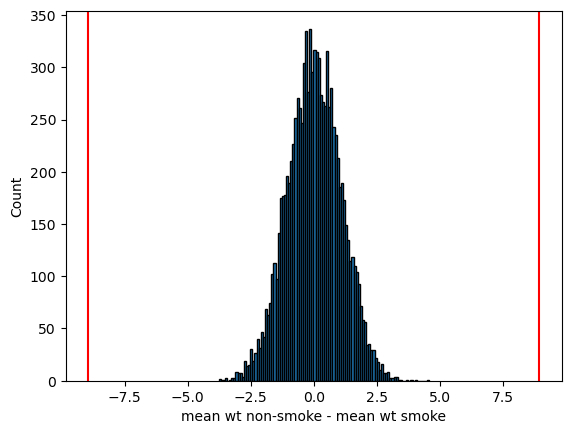

In [52]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("mean wt non-smoke - mean wt smoke");
plt.ylabel("Count");

### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [40]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

0.0

### Step 5: Draw a conclusion

Since the p-value is less than the typical significance level of 0.05, we can reject the null hypothesis. This we conclude there is a difference between in the average weight of babies born to mothers who smoke compared to mothers who do not smoke. 

However, because this was an observational study, where mothers were **not** randomly assigned to treatment and control groups, we can conclude that smoking does causes babies to have less weight when they are born. In particular, it is possible there could be other "lurking/confounding" variables that cause both the mothers to smoke, and the babies to have less weight. 

<br>
<center>
<img src="https://i.ytimg.com/vi/x4c_wI6kQyE/maxresdefault.jpg" alt="smoking" style="width: 300px;"/>
</center>
<br>

## 2. Two-sided hypothesis test

Sometime in hypothesis testing we don't know the direction of an effect, we only know that the null hypothesis is incorrect. 

In these circumstances, we write our alternative hypothesis such that we state that the parameter value is not equal to the value specified by the null hypothesis.

For the baby weight example, we would write our hypotheses as:

$H_0$: $\mu_{non-smoke} =  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} = 0$ 

i.e., the null hypothesis is the same as before.

$H_A$: $\mu_{non-smoke} \ne  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} \ne 0$ 

We now use not equal to ($\ne$) in our alternative hypothesis.


To calculate the p-value, we need to look at the values more extreme than the observed statistic in in both tails. 



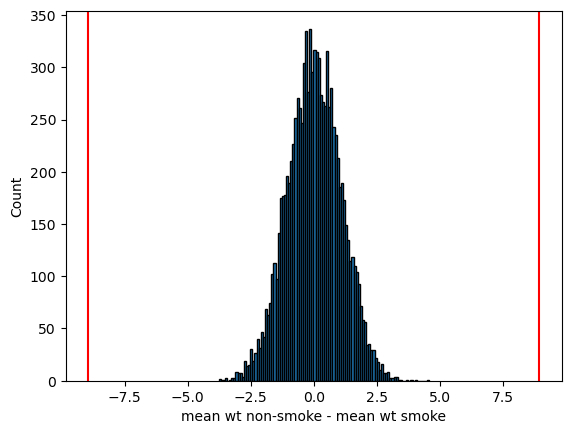

In [56]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put lines showing values more extreme than the observed statistic

plt.axvline(obs_stat, color = "red");
plt.axvline(-1 * obs_stat, color = "red");

plt.xlabel("mean wt non-smoke - mean wt smoke");
plt.ylabel("Count");


When calculating the p-value, we need to get the proportion of statistics in the null distribution that are more extreme than the observed statistic from both tails.

In [57]:
p_value_right = np.mean(np.array(null_dist) >= obs_stat)
p_value_left = np.mean(np.array(null_dist) <= -1 * obs_stat)

p_value = p_value_right + p_value_left

p_value 


0.0

## 3. Using hypothesis tests to generate confidence intervals

There are several methods we that can be used to calculate confidence intervals, including using a computational method called the "bootstrap" and using "parametric methods" that involve using probability distributions. If you take a traditional introductory statistics class you will learn some of these methods.

Below we use a less conventional method to calculate confidence intervals by looking at all parameters values that a hypothesis test fails to reject (at the p-value < 0.05 level). As you will see, the method gives similar results to other methods, although it requires a bit more computation time.

As an example, let's create a confidence interval for the population proportion of movies $\pi$ that pass the Bechdel test. As is the case for all confidence intervals, this confidence interval gives a range of plausible values that likely contains the true population proportion $\pi$.


In [41]:
# To start, let's use a function that generates a statistic p-hat that is consistent with a particular population parameter value pi

def generate_proportion(n, prob_heads):
    
    random_sample = np.random.rand(n) <= prob_heads
    return np.mean(random_sample)

generate_proportion(1794, .5)



0.4955406911928651

In [42]:
# The function below calculates a p-value for the Bechdel data based on a particular pi value that is specified in a null hypothesis.
# (i.e., it is a function that encapsulates the hypothesis test you ran in class 20).


def get_Bechdel_pvalue(null_hypothesis_pi, plot_null_dist = False):
    
    
    # The observed p-hat value
    prop_passed = 803/1794
    
    
    # Generate the null distribution 
    null_dist = []
    
    for i in range(10000):    
        null_dist.append(generate_proportion(1794, null_hypothesis_pi))
    
    
    # Calculate a "two-tailed" p-value which is the proportion of statistcs more extreme than the observed statistic
    
    statistic_deviation = np.abs(null_hypothesis_pi - prop_passed)
    
    pval_left = np.mean(np.array(null_dist) <= null_hypothesis_pi - statistic_deviation)
    pval_right = np.mean(np.array(null_dist) >= null_hypothesis_pi + statistic_deviation)
    
    p_value = pval_left + pval_right

    
    # plot the null distribution and lines indicating values more extreme than the observed statistic 
    if plot_null_dist:
        
        plt.hist(null_dist, edgecolor = "black", bins = 30);
        plt.axvline(null_hypothesis_pi - statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi + statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi, color = "yellow");

        
        plt.title("Pi-null is: " + str(null_hypothesis_pi) + "      "  +
                  "p-value is: " + str(round(p_value, 5)))
      
    # return the p-value
    return p_value
    


0.8486

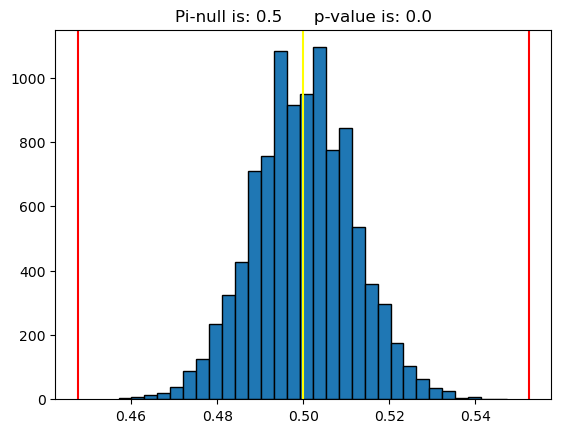

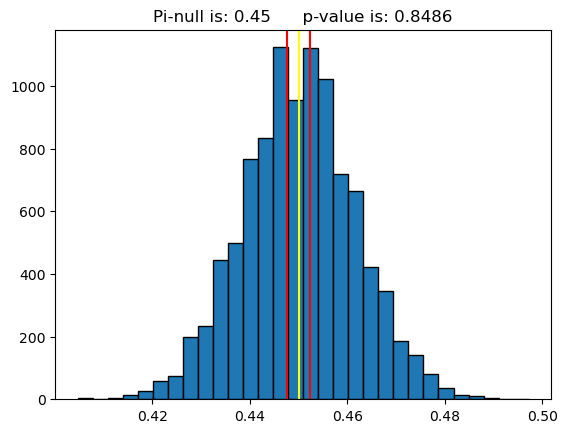

In [58]:
# test the function with the value H0: pi = .5  (as we did in class 20)
get_Bechdel_pvalue(.5, True)


# test the function with the value H0: pi = .45
plt.figure()
get_Bechdel_pvalue(.45, True)

In [44]:
# create a range range of H0: pi = x  values

possible_null_pis = np.round(np.arange(.4, .5, .005), 5)

possible_null_pis    


array([0.4  , 0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 ,
       0.445, 0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485,
       0.49 , 0.495])

In [45]:
%%time


# get the p-value for a range of H0: pi = x  values


pvalues = []

for null_pi in possible_null_pis:
    
    curr_pvalue = get_Bechdel_pvalue(null_pi)
    
    pvalues.append(curr_pvalue)



CPU times: user 4.79 s, sys: 35.6 ms, total: 4.83 s
Wall time: 4.84 s


In [46]:
# view the p-values 
# convention calls a p-value < 0.05 is "statistically significant" indicating a pi imcompatible with the null hypothesis
# our confidence interval is all pi values that are not statistically significant (i.e., pi values that are consistent with particular H0)

pvalue_df = pd.DataFrame({"pi": possible_null_pis, 
                          "p-values": pvalues,
                          "non-significant": np.array(pvalues) > .05})

pvalue_df


,pi,p-values,non-significant
0,0.400,0.0000,False
1,0.405,0.0005,False
2,0.410,0.0007,False
3,0.415,0.0048,False
4,0.420,0.0181,False
5,0.425,0.0588,True
6,0.430,0.1351,True
7,0.435,0.2794,True
8,0.440,0.5184,True
9,0.445,0.8222,True


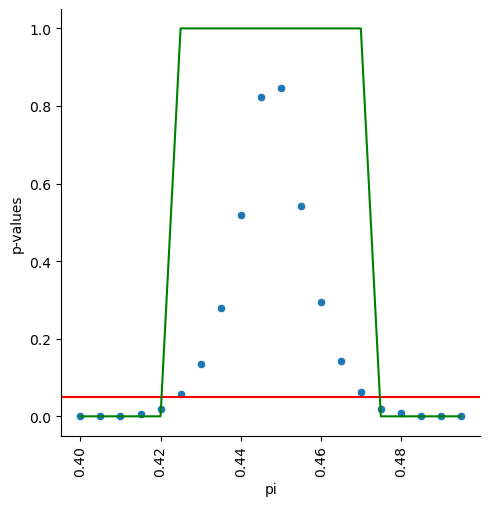

In [47]:
# plot p-values as as function of H0 pi's

sns.relplot(pvalue_df, x = 'pi', y = 'p-values');
plt.xticks(rotation=90);
plt.axhline(.05, color = "red");

plt.plot(pvalue_df['pi'], pvalue_df['non-significant'], color = "green");


In [48]:
# Get all plausible Pi values
fail_to_reject_pis = possible_null_pis[np.array(pvalues) >= .05]

fail_to_reject_pis

array([0.425, 0.43 , 0.435, 0.44 , 0.445, 0.45 , 0.455, 0.46 , 0.465,
       0.47 ])

In [49]:
# get the CI as the max and min plausible pi values 

(min(fail_to_reject_pis), max(fail_to_reject_pis))


(0.425, 0.47)

In [50]:
# using the statsmodels package to compute a confidence interval for a proportion

import statsmodels.api as sm

ci_low, ci_upp = sm.stats.proportion_confint(803, 1794, alpha=0.05, method='normal')
(round(ci_low, 3), round(ci_upp, 3))


(0.425, 0.471)